In [1]:
import pandas as pd 
import numpy as np

import os

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
games_data = pd.read_csv(os.path.join('data', 'games.csv'))
player_data = pd.read_csv(os.path.join('data', 'players.csv'))
plays_data = pd.read_csv(os.path.join('data', 'plays.csv'))
tackles_data = pd.read_csv(os.path.join('data', 'tackles.csv'))

# Calculating Football Distances

## Adding Football Distances to Data

Calculates the distance from the football for each player at each frame, this is 
done for each week.

The data is saved in the edited_data directory.

Below is an example of how the distance is calculated. Below this we edit all of the data
to add store it in the edited_data directory.

In [3]:
# editing the data to give the football an id
week1_data = pd.read_csv(os.path.join('data', 'tracking_week_1.csv'))

week1_data['nflId'] = week1_data['nflId'].fillna(0).astype(int)

# finding the football for each frame and storing it as its own dataframe
football_data = week1_data[week1_data['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
football_data.columns = ['gameId', 'playId', 'frameId', 'football_x', 'football_y']

# merge the football data with the week1 data
week1_data = pd.merge(week1_data, football_data, on=['gameId', 'playId', 'frameId'], how='left')

# calculate the distance between each player and the football
week1_data['fb_distance'] = np.sqrt((week1_data['x'] - week1_data['football_x'])**2 + (week1_data['y'] - week1_data['football_y'])**2)
week1_data.drop(['football_x', 'football_y'], axis=1, inplace=True) # drop the football x and y columns

### Editing the Weekly Data

In [4]:
data_directory = os.listdir('data')
data_directory = [filename for filename in data_directory if 'tracking' in filename]

edit_data = False
if edit_data:
    # iterate through each filename in the data directory
    for filename in data_directory:
        week_data = pd.read_csv(os.path.join('data', filename))
        week_data['nflId'] = week_data['nflId'].fillna(0).astype(int)

        # finding the football for each frame and storing it as its own dataframe
        football_data = week_data[week_data['displayName'] == 'football'][['gameId', 'playId', 'frameId', 'x', 'y']]
        football_data.columns = ['gameId', 'playId', 'frameId', 'football_x', 'football_y']

        # merge the football data with the week1 data
        week_data = pd.merge(week_data, football_data, on=['gameId', 'playId', 'frameId'], how='left')

        # calculate the distance between each player and the football
        week_data['fb_distance'] = np.sqrt((week_data['x'] - week_data['football_x'])**2 + (week_data['y'] - week_data['football_y'])**2)
        week_data.drop(['football_x', 'football_y'], axis=1, inplace=True) # drop the football x and y columns

        # write the data to the edited data directory
        week_data.to_csv(os.path.join('edited_data', filename), index=False)

# as a note for the future
## theres abouta 3 yard difference between where the ball is 
## and where players are.

### Joining all the Weeks Data

Join all the weeks data vertically to allow for paralelized computation

In [5]:
edited_data_directory = os.listdir('edited_data')

write_total_data = False
if write_total_data:
        
    total_data = pd.DataFrame()
    # iterate through each filename in the data directory
    for week, filename in enumerate(edited_data_directory):
        week_data = pd.read_csv(os.path.join('edited_data', filename))
        week_data['week'] = week + 1
        total_data = pd.concat([total_data, week_data], ignore_index=True)

    total_data.to_csv(os.path.join('edited_data', 'total_data.csv'), index=False)
else:
    total_data = pd.read_csv(os.path.join('edited_data', 'total_data.csv'))

In [10]:
def plot_player(data:pd.DataFrame, gameId:int, playId:int, nflId:list, 
                plot_football=False, plot_all_players=False):
    data_subset = data[(data['gameId'] == gameId) & (data['playId'] == playId)]
    traces = []

    if plot_all_players:
        players = data_subset['nflId'].unique()
        nflId = [i for i in players if i != 0]

    for player in nflId:
        player_data = data_subset[data_subset['nflId'] == player]
        traces.append(go.Scatter(x=player_data['x'], y=player_data['y'], mode='lines', name=player_data['displayName'].iloc[0]))
    

    layout = go.Layout(title=f'Game {gameId} Play {playId} Player {nflId}')
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        xaxis=dict(
            range=[0, 120]
        ),
        yaxis=dict(
            range=[0, 53.3]
        )
    )
    if plot_football:
        football_data = data_subset[data_subset['displayName'] == 'football']
        fig.add_trace(go.Scatter(x=football_data['x'], y=football_data['y'], mode='lines', name='football'))

    fig.show()


plot_player(total_data, gameId=2022090800, playId=56, nflId=[43294,43298,43335,46076], 
            plot_football=True, plot_all_players=True)

In [ ]:
def plot_player_movement(data, gameId, playId, nflId, plot_football=False):
    # Filter the data based on gameId, playId, and nflId
    game_data = data[(total_data['gameId'] == gameId) & (data['playId'] == playId) & (data['nflId'] == nflId)]

    # Scatter plot of player movement
    plt.scatter(game_data['x'], game_data['y'])

    # Plotting the field
    ## Plotting the endzones
    plt.axvline(x=10, color='red')
    plt.axvline(x=110, color='blue')

    # Plotting the yard lines
    for i in [20, 30, 40, 50, 60, 70, 80, 90, 100]:
        plt.axvline(x=i, color='black')

    if plot_football:
        # Plotting the football
        football_data = game_data[game_data['displayName'] == 'football']
        plt.scatter(football_data['x'], football_data['y'], color='brown')

    # Setting the x and y axis limits
    plt.xlim(0, 120)
    plt.ylim(0, 53.3)

    # Display the plot
    plt.show()

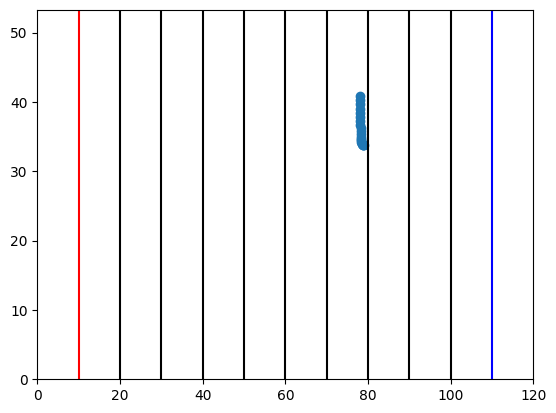

In [ ]:
plot_player_movement(total_data, gameId=2022090800, playId=56, nflId=43294, plot_football=True)

# Notes
## field position
- we should add in starting field position that gives us the amount of yardage on both sides of the football

## traffic
- adding something to designate the nearby traffic of each player
    it may signify something like difficulty in getting to the ball carrier 

In [ ]:
# if a player gets an assist there will not be a tackle
# for any player on that team, so you can say
# any tackle is a solo tackle



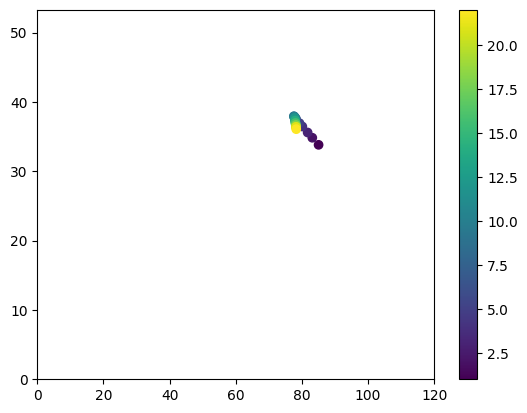

In [ ]:
# we should probably add something that takes the data as it is and plots it 
# as it would be on the football field
## this means the x should be the same way that the football yardage is
### this brings up the question do we train with relative coordinates 
### or do we train with absolute coordinates

## 

play_one = week1_data[(football_week1['gameId'] == unique_plays_list[0][0]) & (football_week1['playId'] == unique_plays_list[0][1])]

x = play_one['x']
y = play_one['y']
frame_id = play_one['frameId']

plt.scatter(x, y, c=frame_id, cmap='viridis')
plt.xlim(0, 120)
plt.ylim(0, 53.3)
plt.colorbar()
plt.show()

# Calculating Tackle Net Force

In [ ]:
# this doesn't work but this method is faster than what i will do

def calc_fb_distance(data):
    data['football_x'] = data.groupby(['gameId', 'playId', 'frameId']).apply(
        lambda group: group.loc[group['displayName'] == 'football', 'x']
    ).reset_index(drop=True) 
    
    data['football_y'] = data.groupby(['gameId', 'playId', 'frameId']).apply(
        lambda group: group.loc[group['displayName'] == 'football', 'y']
    ).reset_index(drop=True)  

    data['fb_distance'] = data.groupby(['gameId', 'playId', 'frameId']).apply(
        lambda group: np.sqrt((group['x'] - group['football_x'])**2 + (group['y'] - group['football_y'])**2)
    ).reset_index(drop=True)

    return data
